In [2]:
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from scipy.spatial.distance import pdist

import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap

from amltlearn.cluster.Triclust import *
import time
import random
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
%matplotlib inline 

# Set seed for reproducibility
seed = 20
random.seed(seed)
np.random.seed(seed)

# Expand recursive calls
import sys
sys.setrecursionlimit(10000)

In [2]:
# Circles dataset 

def get_circles(circles_data):
    """ Input is a list of lists where each element is a circle definition:
        [minimum_radius, maximum_radius, instances]
    """
    
    def get_circle(radius_s, radius_e, num):
        data = np.zeros((num, 2))
        for i in range(len(data)):
            radius = random.uniform(radius_s, radius_e)
            if np.random.randint(10) % 2 == 0:
                # Sample x and compute y
                x = random.uniform(-radius, radius)
                y = np.sqrt(np.square(radius) - np.square(x)) * np.sign(random.uniform(-1, 1))
            else:
                # Sample y and compute x
                y = random.uniform(-radius, radius)
                x = np.sqrt(np.square(radius) - np.square(y)) * np.sign(random.uniform(-1, 1))

            data[i, ...] = np.array([x, y])
        return data
    
    circles = [get_circle(c[0], c[1], c[2]) for c in circles_data]
    return np.vstack(circles)

# Wrapper triangulation
def plot_delaunay(x, env):
    """ Plots the Delaunay tessallation from the input data and model """
    add_labels = False
    # Separate between inner and boundary
    inner_data = env.fcs < env.inner_threshold
    limit_data = env.fcs >= env.inner_threshold
    # Annotate text for debugging
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.triplot(x[:, 0], x[:, 1])
    ax.plot(x[inner_data,0], x[inner_data,1], 'o', color='green')
    ax.plot(x[limit_data,0], x[limit_data,1], 'o', color='red')
    if add_labels:
        for i in range(len(x)):
            ax.annotate(str(i), (x[i, 0], x[i, 1]), fontsize=20)

In [3]:
# MODEL GRID SEARCH FUNCTIONS

def dbscan_test(X, ratio=0.1, n_jobs=2):
    """ Grid search for DBScan """
    # Select eps using subset
    num_subset = int(X.shape[0] * ratio)
    subset = X[np.random.permutation(X.shape[0])[:num_subset]]
    distances = pdist(subset)
    
    # Use range within a stdfrom the mean
    mean, std = np.mean(distances), np.std(distances)
    eps = np.linspace(mean/20.0, mean, 10)
    
    # Values for min samples as ratio of total size
    ratios = [0.005, 0.01, 0.05, 0.025]
    min_samples = [int(X.shape[0] * r) for r in ratios]
    
    # Grid search for eps and min samples
    best = None
    for e in eps:
        for l in min_samples:
            
            print('Testing eps: %f, min samples: %f' % (e, l))
            dbscan = DBSCAN(eps=e, min_samples=l, n_jobs=n_jobs).fit(X)

            if len(np.unique(dbscan.labels_)) == 1 or len(np.unique(dbscan.labels_)) == len(X):
                print('Discarded')
                continue

            # Track best score
            score = silhouette_score(X, dbscan.labels_)
            print('Testing eps: %f, min samples: %f [%f]' % (e, l, score))
            if best is None or score > best['score'] :
                best = {'eps': e, 'min_samples': l, 'score': score}
                
    print('Best configuration found is {}'.format(best))  
    return best


def predict_dbscan(X, ratio = 0.1, n_jobs=2):
    """ Predicts DBSCAN for the input data. Does a grid search for epsilon and min samples parameters """
    best = dbscan_test(X, ratio=ratio, n_jobs=n_jobs)
    return DBSCAN(eps=best['eps'], min_samples=best['min_samples'], n_jobs=n_jobs).fit(X).labels_


# AFFINITY PROPAGATION FUNCTIONS


def af_test(X):
    """ Grid search for affinity propagation """
    damps = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    # Grid search for damping
    best = None
    for d in damps:
            
        print('Testing damping: %f' % d)
        af = AffinityPropagation(damping=d).fit(X)

        if len(np.unique(af.labels_)) == 1 or len(np.unique(af.labels_)) == len(X):
            print('Discarded')
            continue

        # Track best score
        score = silhouette_score(X, af.labels_)
        print('Testing damping: %f [%f]' % (d, score))
        if best is None or score > best['score'] :
            best = {'damp': d, 'score': score}
            
    return best


def predict_af(X):
    """ Predicts AP for the input data. Does a grid search for damping parameter """
    best = af_test(X)
    return AffinityPropagation(damping=best['damp']).fit(X).labels_


# TRICLUST FUNCTIONS


def triclust_test(X, ratio=0.1):
    """ Grid search for Triclust """
    def get_s(size):
        """ Returns a set of combinations for smin and smax"""
        result = [[size * 0.5, 10000]] # Smax has no impact if N < Smin
        result = result + [[size * 0.25, size * 0.5]] # Smin has no impact if N > Smax
        
        # In between Smin and Smax
        result = result + [[size*0.25, size*1.25]] + [[size*0.50, size*1.50]] + [[size*0.75, size*1.75]]
        # More extreme situations where Smin < N < Smax
        result = result + [[size*0.1, size*10]]
        result = result + [[size*0.05, size*20]]
        return result
    
    # Smin, smax, B value
    size = X.shape[0]
    mins_maxs = get_s(size)
    bs = [size * 0.5, size] # Less and equal so explore two possibilities
    
    # Grid search
    best = None
    for mm in mins_maxs:
        for b in bs:
                
            s_min, s_max = mm
            print('Testing smin: %f, smax: %f, rc: %f' % (s_min, s_max, b))
            tc = Triclust(s_min=s_min, s_max=s_max, rc_param=b, verbose=False)
            tc.fit(X)

            # We count boundary as cluster here as well
            if len(np.unique(tc.complete_clustering)) == 1 \
                or len(np.unique(tc.complete_clustering)) == len(X):
                print('Discarded')
                continue

            # Track best score
            score = silhouette_score(X, tc.complete_clustering)
            print('Testing smin: %f, smax: %f, rc: %f [%f]' % (s_min, s_max, b, score))
            if best is None or score > best['score'] :
                best = {'s_min': s_min, 's_max': s_max, 'rc': b, 'score': score}
                    
    print('Best configuration is {}'.format(best))
    return best


def predict_tri(X, ratio = 0.1):
    """ Predicts Triclust for the input data. Does a grid search for s_min, s_max, rc param"""
    best = triclust_test(X, ratio=ratio)
    tc = Triclust(s_min=best['s_min'], s_max=best['s_max'], rc_param=best['rc'])
    tc.fit(X)
    return tc.complete_clustering


# KMEANS FUNCTIONS


def kmeans_test(X, max_clusters=10, n_jobs=2):
    """ Grid search for kmeans """
    clus = range(2, max_clusters+1)
    
    # Grid search for preference and damping
    best = None
    for k in clus:
        kmeans = KMeans(n_clusters=k, n_jobs=n_jobs).fit(X)
        
        # Track best score
        score = silhouette_score(X, kmeans.labels_)
        print('Testing k: %f [%f]' % (k, score))
        if best is None or score > best['score']:
            best = {'k': k, 'score': score}
                    
    print('Best configuration is {}'.format(best))
    return best


def predict_kmeans(X, n_jobs = 2):
    """ Predicts Kmeans for the input data. Does a grid search for num of clusters """
    best = kmeans_test(X, n_jobs=n_jobs)
    return KMeans(n_clusters=best['k'], n_jobs=n_jobs).fit(X).labels_


def plot_all(X, km, tri, af, db, path=None):
    """ Plots all predictions in a grid """
    f, axarr = plt.subplots(2, 2, figsize=(10, 6))

    axarr[0, 0].scatter(X[:, 0], X[:, 1], c=km)
    axarr[0, 0].set_title('KMeans')

    axarr[0, 1].scatter(X[:, 0], X[:, 1], c=tri)
    axarr[0, 1].set_title('Triclust')

    axarr[1, 0].scatter(X[:, 0], X[:, 1], c=af)
    axarr[1, 0].set_title('Affinity propagation')

    axarr[1, 1].scatter(X[:, 0], X[:, 1], c=db)
    axarr[1, 1].set_title('DBSCAN')

    if path is not None:
        plt.savefig(path)

In [4]:
%%capture
# Circle data: grid search and predictions
circles1 = get_circles([[0, 2, 500], [3.5, 5, 800]])
kmeans_clus = predict_kmeans(circles1)
tri_clus = predict_tri(circles1)
af_clus = predict_af(circles1)
db_clus = DBSCAN(eps=0.75, min_samples=12).fit(circles1).labels_
plot_all(circles1, kmeans_clus, tri_clus, af_clus, db_clus)

Clustering boundary points ...: 100%|██████████| 161/161 [00:00<00:00, 56198.65it/s]


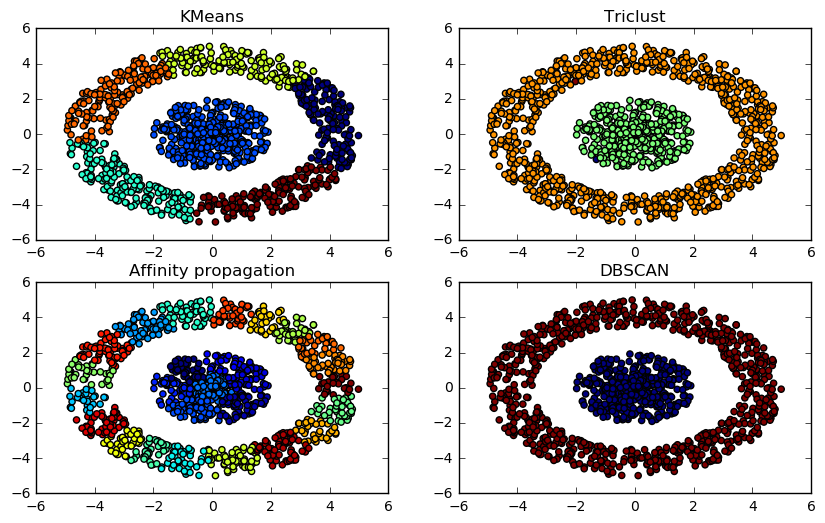

In [5]:
plot_all(circles1, kmeans_clus, tri_clus, af_clus, db_clus)

In [6]:
%%capture
# Circle data: this time with 3 circles
circles2 = get_circles([[0, 2, 500], [3, 5, 800], [6, 8, 1100]])
kmeans_clus = predict_kmeans(circles2)
tri_clus = predict_tri(circles2)
af_clus = predict_af(circles2)
db_clus = DBSCAN(eps=0.75, min_samples=12).fit(circles2).labels_

Clustering boundary points ...: 100%|██████████| 400/400 [00:00<00:00, 58600.13it/s]


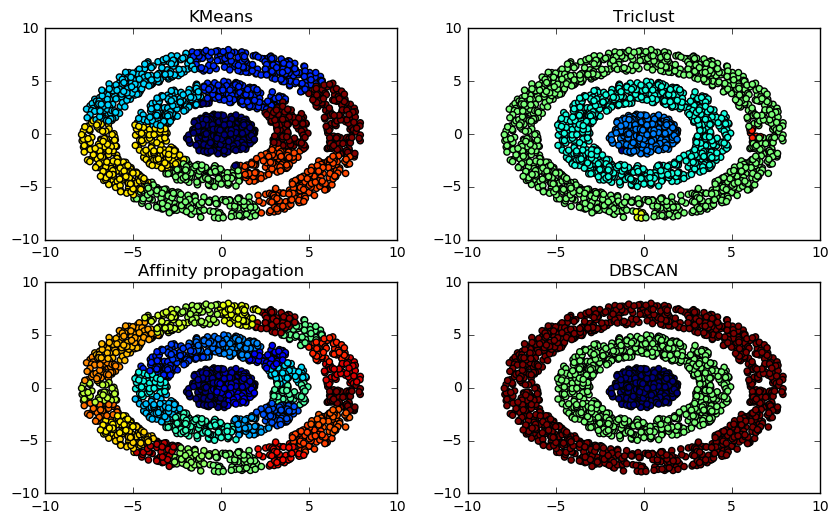

In [7]:
plot_all(circles2, kmeans_clus, tri_clus, af_clus, db_clus)

In [12]:
%%capture
# Make blobs
x_blobs1, _ = datasets.make_blobs(n_samples=500, n_features=2, centers=4, random_state=seed)
kmeans_clus = predict_kmeans(x_blobs1)
tri_clus = predict_tri(x_blobs1)
db_clus = predict_dbscan(x_blobs1)
af_clus = AffinityPropagation(preference=-120, damping=0.75).fit(x_blobs1).labels_ # Hard-coded

Clustering boundary points ...: 100%|██████████| 51/51 [00:00<00:00, 36874.59it/s]


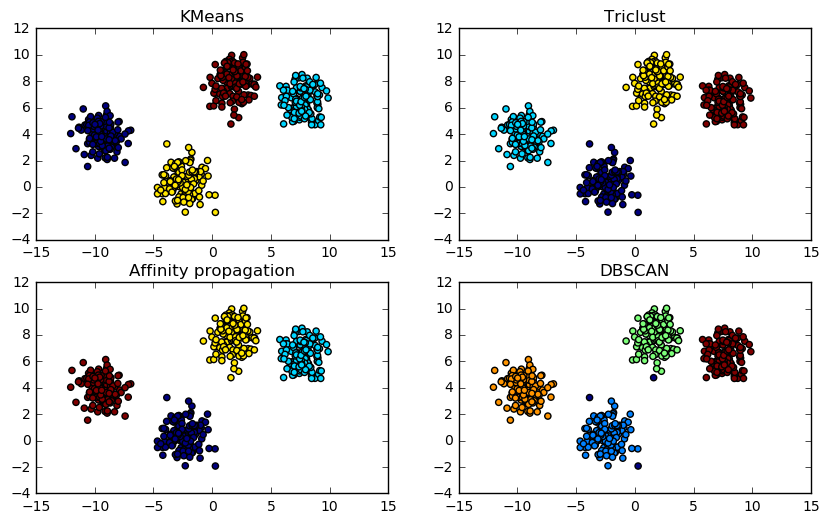

In [13]:
plot_all(x_blobs1, kmeans_clus, tri_clus, af_clus, db_clus)

In [14]:
%%capture
# Make blobs with higher std
x_blobs2, _ = datasets.make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1.75, random_state=20)

kmeans_clus = predict_kmeans(x_blobs2)

tri = Triclust(s_min=250, s_max=600, rc_param=1000, inner_ratio=0.55)
tri.fit(x_blobs2)
tri_clus = tri.complete_clustering # Hard-coded

db_clus = predict_dbscan(x_blobs2)
af_clus = AffinityPropagation(preference=-250, damping=0.85).fit(x_blobs2).labels_ # Hard-coded
plot_all(x_blobs2, kmeans_clus, tri_clus, af_clus, db_clus)

Clustering boundary points ...: 100%|██████████| 162/162 [00:00<00:00, 56660.88it/s]


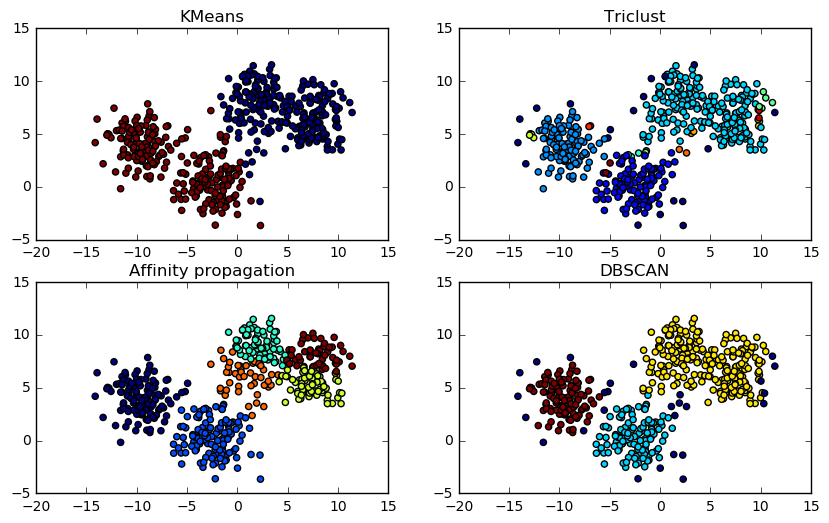

In [15]:
plot_all(x_blobs2, kmeans_clus, tri_clus, af_clus, db_clus)

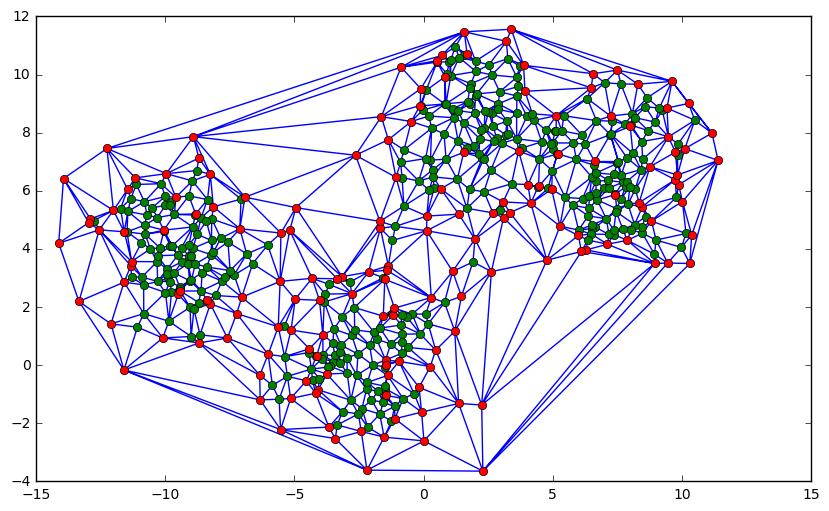

In [53]:
# Before going to the next algoritjm, let's show an example of the Delaunay trinagulation
plot_delaunay(x_blobs2, tri)

In [54]:
%%capture
# Make moons
x_moons, _ = datasets.make_moons(n_samples=500, noise=0.05, random_state=seed)
kmeans_clus = predict_kmeans(x_moons)
tri_clus = predict_tri(x_moons)
af_clus = AffinityPropagation(preference=-250, damping=0.85).fit(x_moons).labels_ # Hard-coded
db_clus = predict_dbscan(x_moons)

Clustering boundary points ...: 100%|██████████| 66/66 [00:00<00:00, 45930.66it/s]


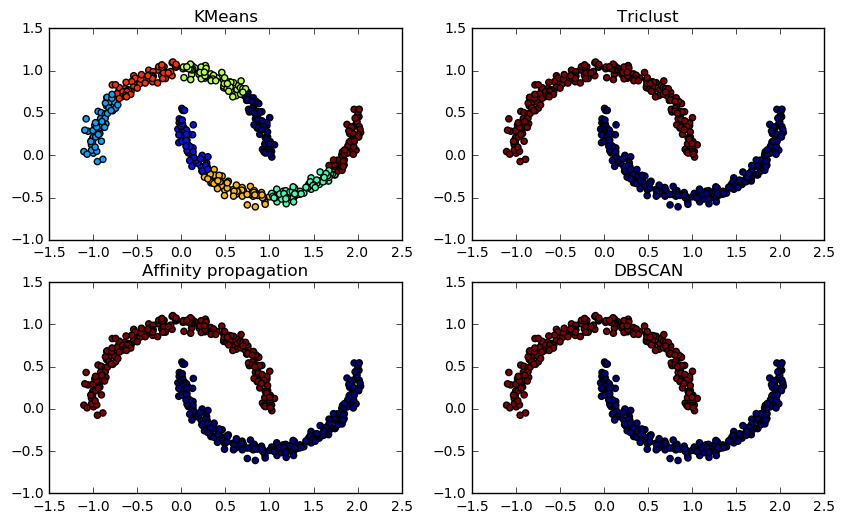

In [55]:
plot_all(x_moons, kmeans_clus, tri_clus, db_clus, db_clus)

In [123]:
# Real data: we will deal with the distribution of Airbnb apartments in an city of the USA
# Here we have some plot helper functions

def plot_map_core(data, clusters, point_size=25, alpha=0.7, min_size=None):
    """ Core plot function """
    my_map = Basemap(projection='merc',
        resolution = 'h', area_thresh = 0.1,
        llcrnrlon=np.min(data[:, 0]), # lower-left corner longitude
        llcrnrlat=np.min(data[:, 1]), # Lower-left corner latitude
        urcrnrlon=np.max(data[:, 0]), # Upper-right corner longitude
        urcrnrlat=np.max(data[:, 1])) # # Upper-right corner latitude

    my_map.drawcoastlines()
    my_map.fillcontinents(color='coral', lake_color='aqua')
    my_map.drawmapboundary()

    # Track only populated clusters
    if min_size is not None:
        unique, counts = np.unique(clusters, return_counts=True)
        populated = np.where(counts >= min_size)[0]
        pop_ids = unique[populated]
    
    # Convert data to base map
    color = cm.rainbow(np.linspace(0, 1, len(np.unique(clusters))))
    xs, ys, cs = [], [], []
    for i in range(len(data)):
        
        # If min size provided, plot only if point belonging to populated cluster
        if min_size is None or clusters[i] in pop_ids:
            x, y = my_map(data[i, 0], data[i, 1])
            xs.append(x)
            ys.append(y)
            cs.append('black' if clusters[i] < 0 else color[clusters[i]])

    my_map.scatter(xs, ys, s=[point_size] * len(xs), zorder=2, c=cs, marker='o', alpha=alpha)

    
def plot_map(data, clusters, point_size=25, alpha=0.7, path=None, min_size=None):
    """ Plots clustered map in figure """
    plt.figure(figsize=(6,14))
    plot_map_core(data, clusters, point_size, alpha, min_size)
    if path is None:
        plt.show()
    else:
        plt.savefig(path)

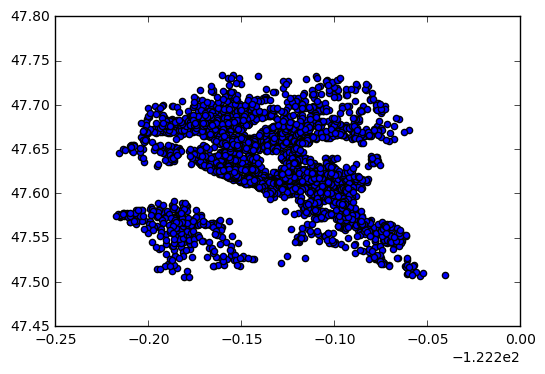

In [3]:
# REAL DATA
# Seattle dataset. Based on the Kaggle Seattle Airbnb thread
# https://www.kaggle.com/airbnb/seattle
# Take a look and visualize the data
seattle = pd.read_csv('../data/listings.csv')[['longitude', 'latitude']].as_matrix()
plt.scatter(seattle[:, 0], seattle[:, 1])

/home/walle/envs/amlt/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


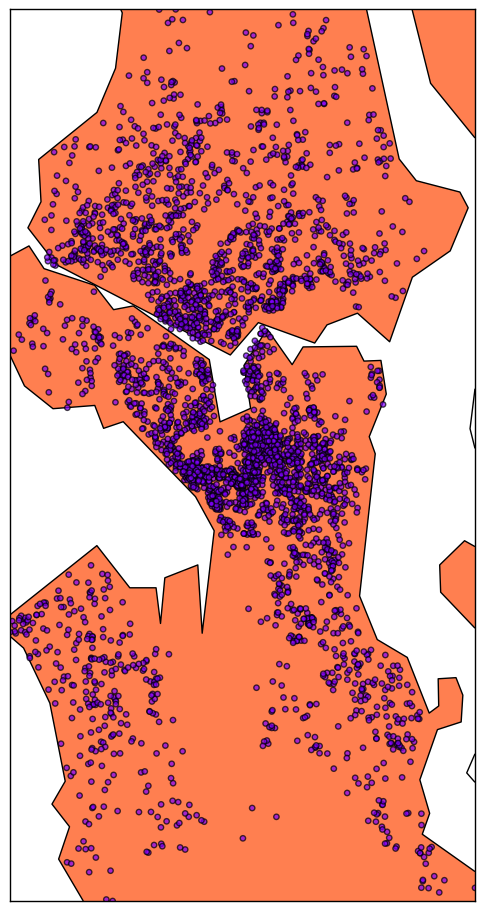

In [58]:
# Seattle - Show map
plot_map(seattle, np.zeros((len(seattle))) * 5)

Testing k: 2.000000 [0.409772]
Testing k: 3.000000 [0.444179]
Testing k: 4.000000 [0.445316]
Testing k: 5.000000 [0.474352]
Testing k: 6.000000 [0.428454]
Testing k: 7.000000 [0.392882]
Testing k: 8.000000 [0.406594]
Testing k: 9.000000 [0.393466]
Testing k: 10.000000 [0.398677]
Best configuration is {'k': 5, 'score': 0.47435151315539581}


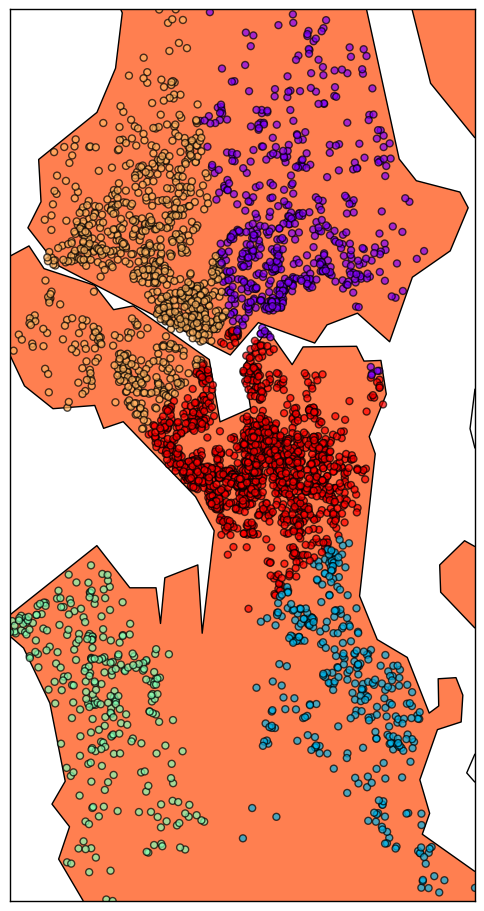

In [126]:
# Seattle - K means fine tune
kmeans_clus = predict_kmeans(seattle)
plot_map(seattle, kmeans_clus)

Testing damping: 0.500000
Testing damping: 0.500000 [0.208029]
Testing damping: 0.600000
Testing damping: 0.600000 [0.298941]
Testing damping: 0.700000
Testing damping: 0.700000 [0.387721]
Testing damping: 0.800000
Testing damping: 0.800000 [0.396110]
Testing damping: 0.900000
Testing damping: 0.900000 [0.401324]


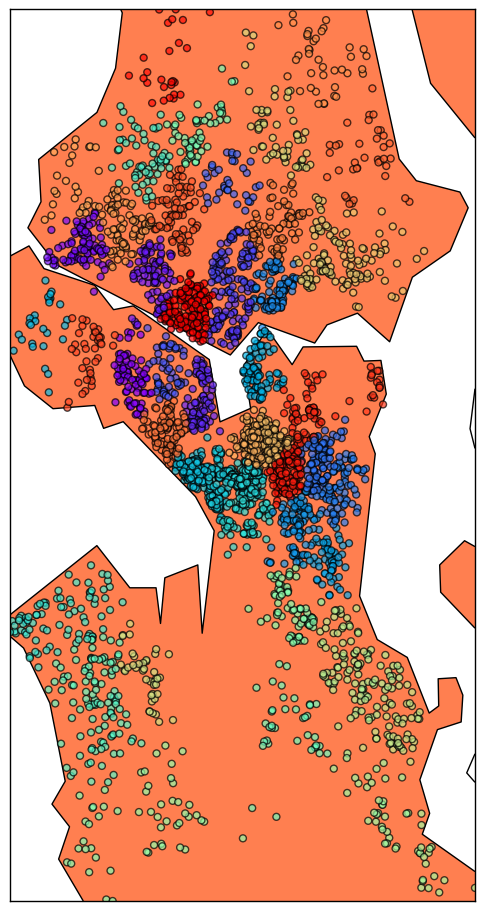

Number of clusters: 53. Counts: [ 75  94  87  94  75  90  53  35 103  77 106 100  64  82  28 178 148 186
  84  38  43  61  56  52  38  54  20  75  34  31  21  46  56  47  41  57
  63  57 165 147  27  75  39  72  93  37  74  40  17  63 142  26 152]


In [127]:
# Seattle - Affinity Propagation
af_clus = predict_af(seattle)
plot_map(seattle, af_clus)
unique, counts = np.unique(af_clus, return_counts=True)
print('Number of clusters: {}. Counts: {}'.format(len(unique), counts))

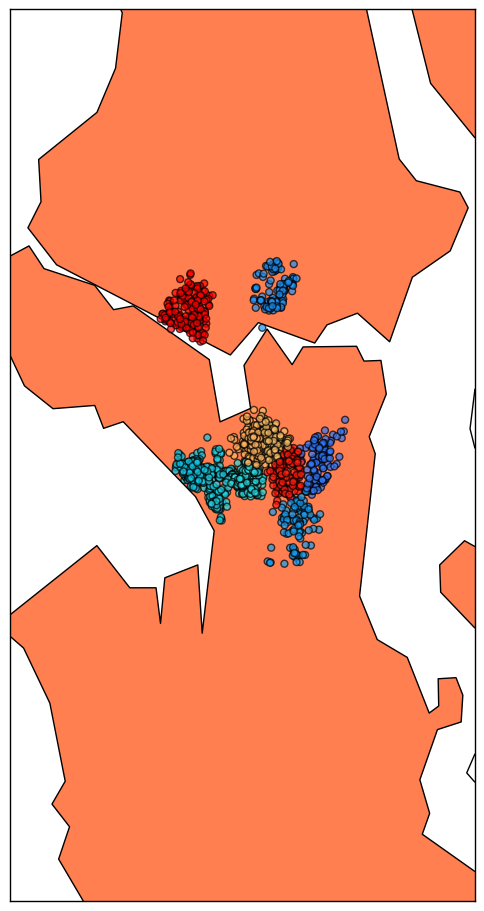

In [128]:
# Plot only populated clusters for AP
plot_map(seattle, af_clus, min_size=100)

Testing eps: 0.003240, min samples: 19.000000
Testing eps: 0.003240, min samples: 19.000000 [-0.272067]
Testing eps: 0.003240, min samples: 38.000000
Testing eps: 0.003240, min samples: 38.000000 [-0.095281]
Testing eps: 0.003240, min samples: 190.000000
Discarded
Testing eps: 0.003240, min samples: 95.000000
Testing eps: 0.003240, min samples: 95.000000 [-0.211296]
Testing eps: 0.010079, min samples: 19.000000
Testing eps: 0.010079, min samples: 19.000000 [0.133840]
Testing eps: 0.010079, min samples: 38.000000
Testing eps: 0.010079, min samples: 38.000000 [0.329740]
Testing eps: 0.010079, min samples: 190.000000
Testing eps: 0.010079, min samples: 190.000000 [0.155718]
Testing eps: 0.010079, min samples: 95.000000
Testing eps: 0.010079, min samples: 95.000000 [0.176525]
Testing eps: 0.016918, min samples: 19.000000
Testing eps: 0.016918, min samples: 19.000000 [0.373138]
Testing eps: 0.016918, min samples: 38.000000
Testing eps: 0.016918, min samples: 38.000000 [0.414832]
Testing eps

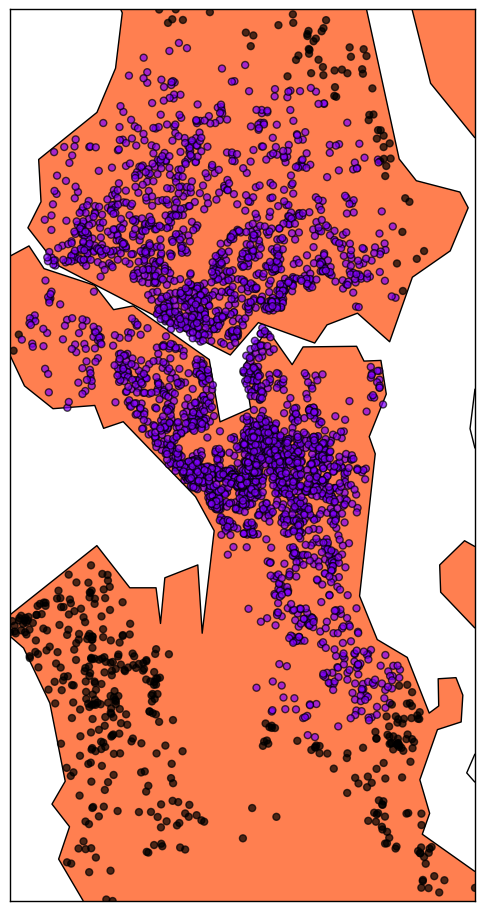

Number of clusters: 2


In [129]:
# DBSCAN grid search
db_clus = predict_dbscan(seattle)
plot_map(seattle, db_clus)
print('Number of clusters: {}'.format(len(np.unique(db_clus))))

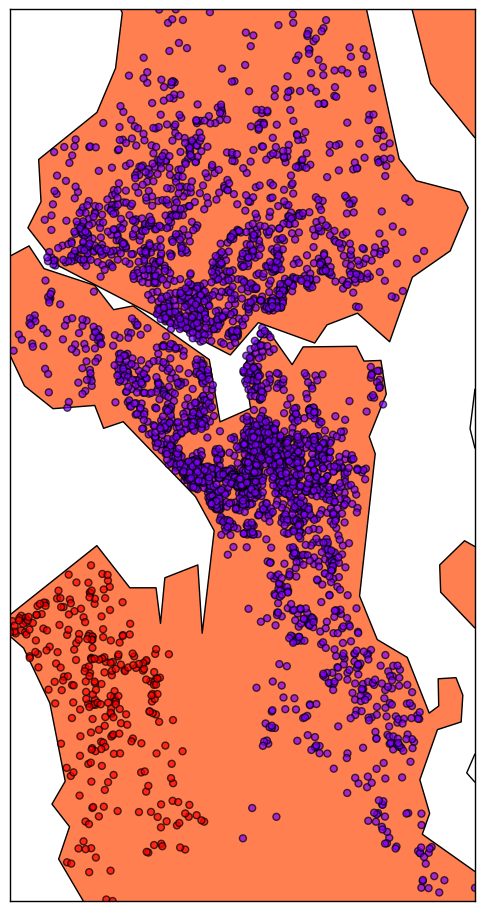

Number of clusters: 2


In [130]:
# DBSCAN manual search
db_clus = DBSCAN(eps=0.025, min_samples=25).fit(seattle).labels_
plot_map(seattle, db_clus)
print('Number of clusters: {}'.format(len(np.unique(db_clus))))

Computing Delaunay and stats ...


Clustering boundary points ...: 100%|██████████| 1611/1611 [00:00<00:00, 65650.61it/s]


Showing inner ratio of 0.75 (all)


/home/walle/envs/amlt/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


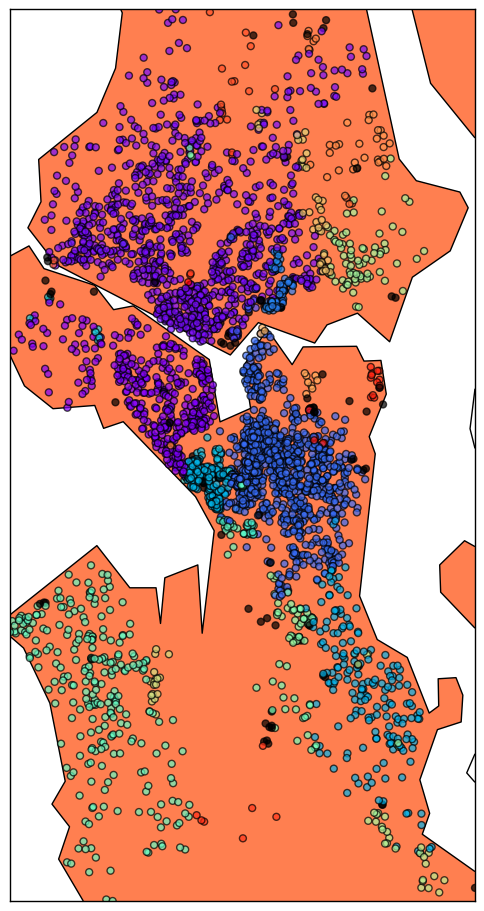

Showing inner ratio of 0.75 (> 100)


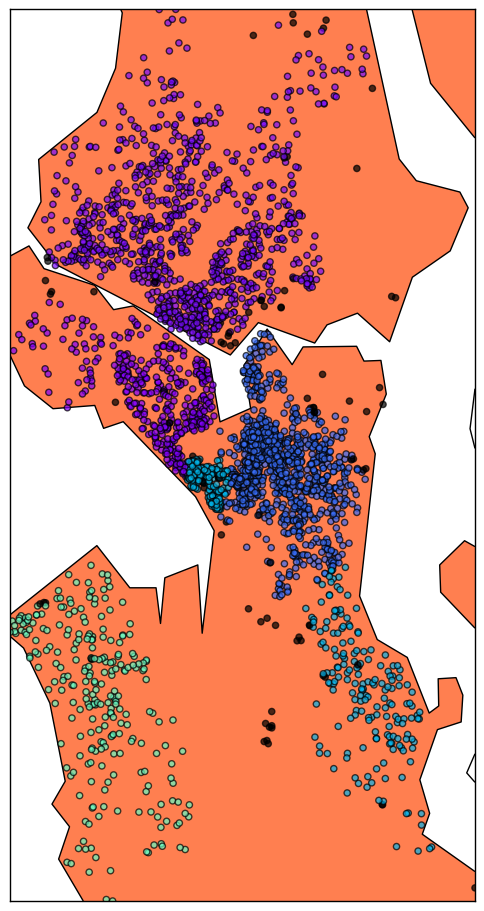

Counts [ 102  387    1  939    3    3    2    3    1    2   16    3    4    3    3
    5 1115    1    6   39   16   14    3    1    1    2    1  186  261    2
    6    5    2    7    3    1    6    2    1    1    2    1   16    6    1
    2   11   14  256    1    1   19    3    1    2   25    7    4    2    4
    5   71    9    4    6    4    3    2    2    5    4    9    3    5    6
    2   14   12    2    1    3    8    1    1    3   16    4    8    6    5
    1    2    1    2    2   11    2    2    2    5    2   13    2    3    3
    4]
Computing Delaunay and stats ...


Clustering boundary points ...: 100%|██████████| 1418/1418 [00:00<00:00, 61703.34it/s]


Showing inner ratio of 0.8 (all)


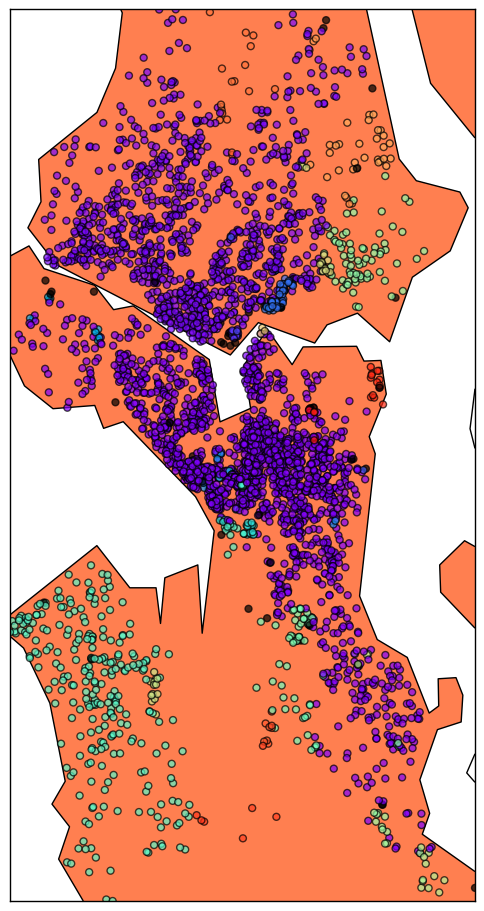

Showing inner ratio of 0.8 (> 100)


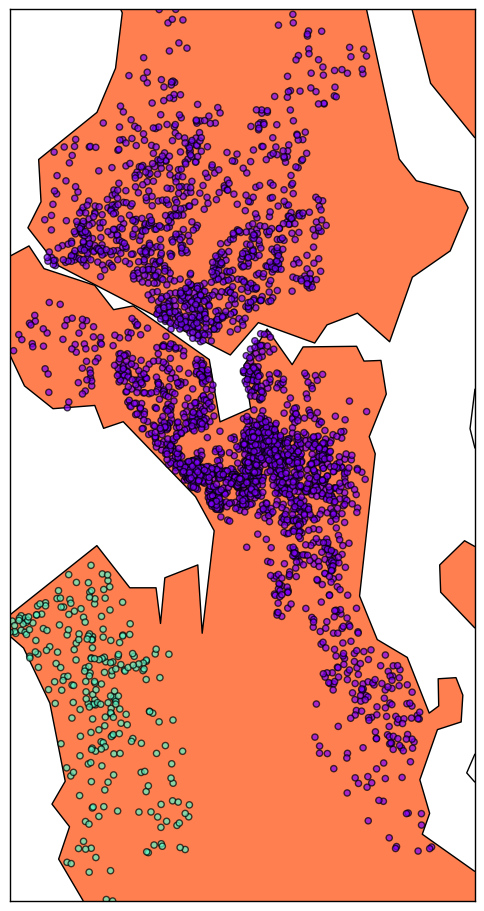

Counts [  53 2012 1027    2    1    1   16    1    3    4    2    4   39   14    1
    2    2    4    2    7    3    1    6    2    2    1   16    6    1    2
   11   14  263    1    1   22    3   28    2    5   71    8    2    6    4
    3    2    2   13    4   12    2    1    3    1    1    2   21    8    3
    2    1    2   12    2    2    6    2    5    2   14    6    3    3]
Computing Delaunay and stats ...


Clustering boundary points ...: 100%|██████████| 1093/1093 [00:00<00:00, 61716.65it/s]


Showing inner ratio of 0.9 (all)


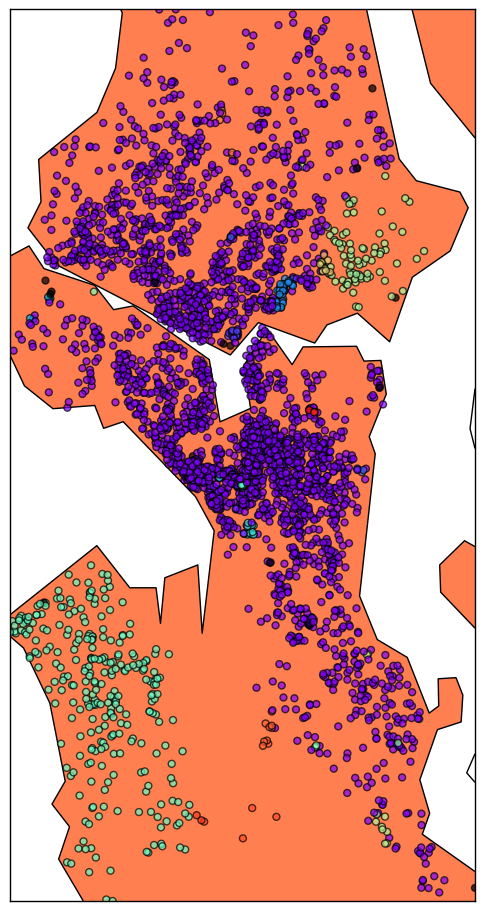

Showing inner ratio of 0.9 (> 100)


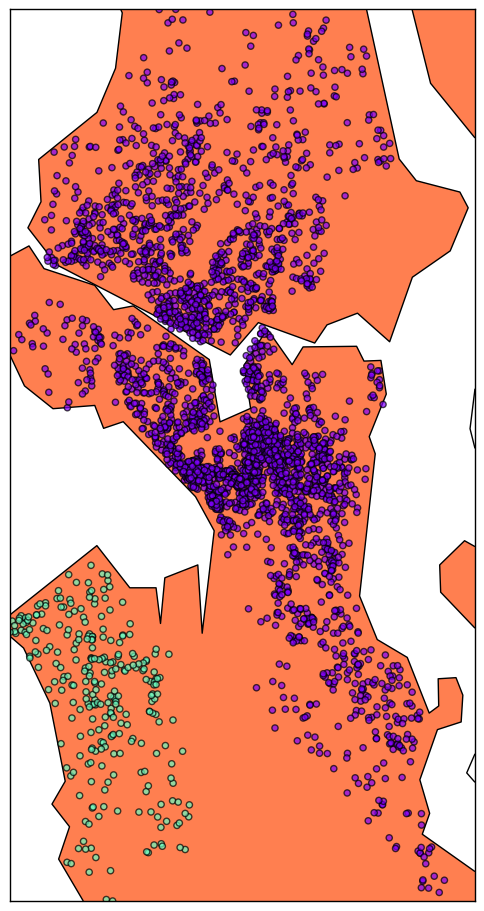

Counts [  21 3272    1    1   20    1    3    4    1   39    2    2    3    1    2
    2   14    1    1   10  278    1    1    3    2   73    6    2    2    3
   12    2    1    1    1    2    2    2    9    4    2    6    2]
Computing Delaunay and stats ...


Clustering boundary points ...: 100%|██████████| 842/842 [00:00<00:00, 60780.74it/s]


Showing inner ratio of 1.0 (all)


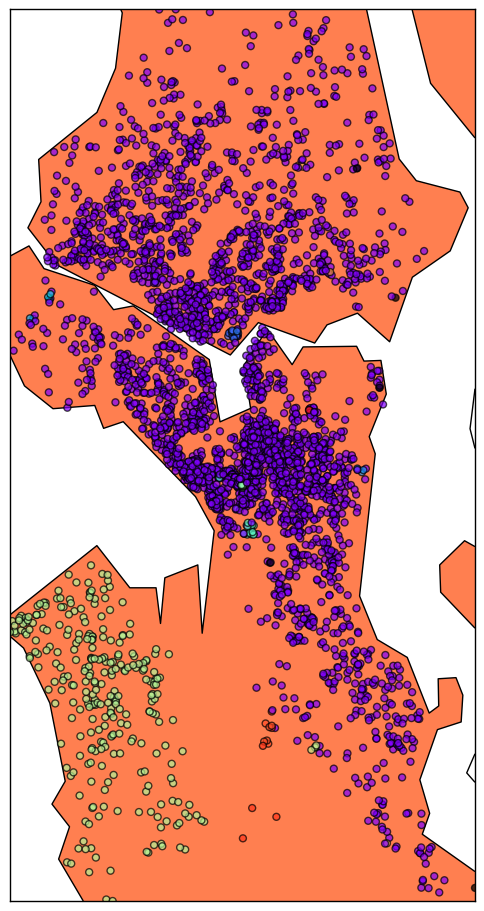

Showing inner ratio of 1.0 (> 100)


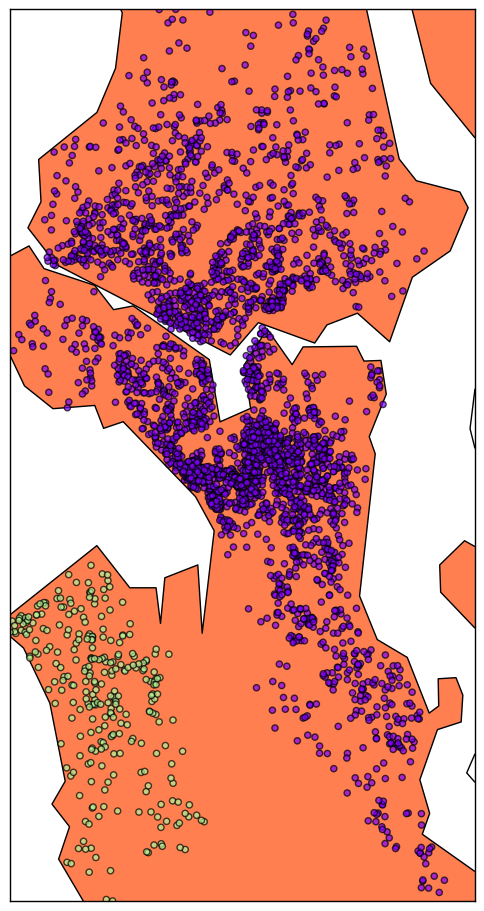

Counts [   6 3435    1    1    1   20    1    4    2    2    1    1    2    2   14
    1    1   10    1  283    4    2    1    1    3    2    1    1    8    4
    2]


In [125]:
def plot_triclust(data, s_min, s_max, rc, inner, min_size=None, point_size=20):
    """ Summary of the Triclust input model """
    tri = Triclust(s_min=s_min, s_max=s_max, rc_param=rc, inner_ratio=inner)
    tri.fit(data)
    tri_clus = tri.complete_clustering # Hard-coded
    
    print('Showing inner ratio of {} (all)'.format(inner))
    plot_map(data, tri_clus - 1)
    
    # Check if threshold provided
    if min_size is not None:
        print('Showing inner ratio of {} (> {})'.format(inner, min_size))
        plot_map(data, tri_clus - 1, point_size=point_size, min_size=min_size)
    
    # Show cluster counts
    uniq, counts = np.unique(tri_clus, return_counts=True)
    print("Counts {}".format(counts))

plot_triclust(seattle, s_min=250, s_max=10000, rc=2500, inner=0.75, min_size=100)
plot_triclust(seattle, s_min=250, s_max=10000, rc=2500, inner=0.80, min_size=100)
plot_triclust(seattle, s_min=250, s_max=10000, rc=2500, inner=0.90, min_size=100)
plot_triclust(seattle, s_min=250, s_max=10000, rc=2500, inner=1.00, min_size=100)

In [96]:
# Track time of all settings
before = time.time()
KMeans(n_clusters=5, n_jobs=2).fit(seattle)
print('KMeans lapsed %f (sec)' % (time.time() - before))

before = time.time()
AffinityPropagation(damping=0.9).fit(seattle)
print('AP lapsed %f (sec)' % (time.time() - before))

before = time.time()
DBSCAN(eps=0.025, min_samples=25).fit(seattle)
print('DBSCAN lapsed %f (sec)' % (time.time() - before))

before = time.time()
tri = Triclust(s_min=250, s_max=10000, rc_param=2500, inner_ratio=0.75)
tri.fit(seattle)
print('Triclust lapsed %f (sec)' % (time.time() - before))

KMeans lapsed 0.154085 (sec)
AP lapsed 21.830719 (sec)
DBSCAN lapsed 0.105250 (sec)
Computing Delaunay and stats ...


Clustering boundary points ...: 100%|██████████| 1611/1611 [00:00<00:00, 63530.34it/s]

Triclust lapsed 1.072636 (sec)
